
# 📦 Amazon Reviews Clustering Project

## Walidacja (Milestone 1)

### Nasze zastrzeżenia:
- Co do usuwania bardzo krótkich komentarzy: jeśli usuniecie teraz zbyt krótkie komentarze, w zastosowaniu biznesowym model nie będzie umiał sensownie przyporządkowywać takich komentarzy do klastrów. Jeśli model ma być używany do automatycznego przypisywania recenzji do zespołów obsługi klienta (tak, jak macie napiane w potencjalnych zastosowaniach), te komentarze musiałyby zostać wcześniej odsortowane, może przypożądkowane do ręcznie zrobionych klastrów typu krótkie recencje 1-gwaizdkowe. Warto by było skomentować od strony biznesowej co się z takimi komentarzami dzieje.
- Stosowanie PCA do cech z BERTa może nie mieć większgo sensu ze względu na to, że te embeddingi wychodzą z wcześniej wytrenowanego modelu. PCA ma sens dla TF-IDF, bo są one otrzymywane poprzez liniowe wyliczenie częstości występowania. Dla BERT PCA może dawać gorsze wyniki przez to, że nie uwzględnia zależności nieliniowych. 
- W opisie klastrów nazwy są pozamieniane.
- Przy wykresie do ustalania najlepszej wartości eps dla DBSCAN jako liczba n_neighbors powinno być ustawione na docelowe min_samples.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv("/Users/lila/Downloads/cleaned_amazon_reviews.csv")

df=df[["Text"]]

df.head()

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


In [3]:
df["Text"].isna().sum()

np.int64(0)

In [4]:
df["length"]=df["Text"].str.len()

### Wstępne czyszczenie tekstu

Usuwamy znaki specjalne, liczby oraz zamieniamy tekst na małe litery, aby ujednolicić dane i zmniejszyć szum językowy przed dalszym przetwarzaniem.

In [5]:
def clean_text(text):
    text=text.lower()

    text = re.sub(r"\s+", " ", text).strip()

    text = re.sub(r"[^a-z\s]", "", text)

    return text


df["clean_text"]=df["Text"].apply(clean_text)

df[["Text","clean_text"]].sample(5)


,Text,clean_text
19880,It's really important to me to feed my pets qu...,its really important to me to feed my pets qua...
19813,We save lots of money using these instead of f...,we save lots of money using these instead of f...
5057,Pretty close to the taste of a freshly opened ...,pretty close to the taste of a freshly opened ...
436,I have been ordering the sea salt chips for ab...,i have been ordering the sea salt chips for ab...
619,"I try to be good, but when I feel like indulgi...",i try to be good but when i feel like indulgin...


## 🧠 Analiza złożoności tekstu

W tej sekcji obliczamy podstawowe wskaźniki złożoności językowej dla każdej recenzji. Metryki takie jak liczba słów, długość słów, liczba unikalnych słów czy średnia długość zdania pozwalają ocenić, jak rozbudowane i wymagające językowo są opinie użytkowników. 

Metryki zdaniowe (np. liczba zdań, średnia liczba słów w zdaniu) zostały wyliczone na podstawie oryginalnej wersji tekstu (`Text`), natomiast metryki słowne na podstawie oczyszczonego tekstu (`clean_text`).

In [6]:
import pandas as pd
import re

def analyze_text_complexity(row):
    clean_text = row['clean_text']
    raw_text = row['Text']
    
    words = clean_text.split()
    num_words = len(words)
    text_len = len(clean_text)
    
    avg_word_length = sum(len(word) for word in words) / num_words if num_words > 0 else 0
    unique_words = len(set(words))

    sentences = re.split(r'[.!?]+', raw_text)
    sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
    num_sentences = len(sentences)
    avg_words_per_sentence = sum(len(s.split()) for s in sentences) / num_sentences if num_sentences > 0 else 0

    return pd.Series({
        'num_words': num_words,
        'avg_word_length': avg_word_length,
        'num_unique_words': unique_words,
        'text_length': text_len,
        'num_sentences': num_sentences,
        'avg_words_per_sentence': avg_words_per_sentence,
    })

# Analiza złożoności tekstu
complexity_features = df.apply(analyze_text_complexity, axis=1)

# Lista wskaźników do wizualizacji
features = [
    'num_words', 'avg_word_length',
    'num_unique_words', 'text_length', 'num_sentences',
    'avg_words_per_sentence'
]

### Detekcja języka

Sprawdzamy, w jakim języku są napisane recenzje, i zachowujemy tylko te, które są w języku angielskim.


In [7]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "error"

df['lang'] = df['clean_text'].apply(detect_language)

print(df['lang'].value_counts())

lang
en    21248
es        5
sq        1
fr        1
Name: count, dtype: int64


In [8]:
df=df[df["lang"]=="en"].reset_index(drop=True)

print(df['lang'].value_counts())

lang
en    21248
Name: count, dtype: int64


## 🔤 Tokenizacja i lematyzacja tekstu

Na tym etapie dokonujemy tokenizacji i lematyzacji tekstów z kolumny `clean_text`. 
Za pomocą biblioteki spaCy identyfikujemy pojedyncze słowa (tokeny), usuwamy stop words oraz pomijamy tokeny krótsze niż 3 znaki. Każdy token zamieniany jest na swoją formę podstawową (lemat), co pozwala uprościć analizę i zmniejszyć różnorodność słów o tym samym znaczeniu.

In [9]:
import spacy

# Załaduj angielski model językowy
nlp = spacy.load("en_core_web_sm")

def spacy_preprocess(text):
    doc = nlp(text)
    tokens = []
    
    for token in doc:
        if not token.is_stop and len(token.text) > 2:
            lemma=token.lemma_
            tokens.append(lemma)

    return tokens

# Stosujemy funkcję do oczyszczonych tekstów
df['tokens'] = df['clean_text'].apply(spacy_preprocess)

# Podgląd
df[['Text', 'tokens']].sample(5)


,Text,tokens
2220,Since a DOP product is not readily available a...,"[dop, product, readily, available, local, groc..."
10544,Ingredients on Deep River Snacks's website are...,"[ingredient, deep, river, snackss, website, po..."
1228,These potatoes are very good along with all th...,"[potato, good, steak, hamburger, definately, r..."
2016,"Makes very good, light waffles. Seems to be ex...","[make, good, light, waffle, exactly, carbon, g..."
1470,"These papers are great, they leave a delicious...","[paper, great, leave, delicious, strawberry, t..."


In [10]:
df['num_tokens'] = df['tokens'].apply(len)

## 📊 Najczęściej występujące słowa

Poniżej prezentujemy 20 najczęściej pojawiających się słów w zlematyzowanych recenzjach klientów. Analiza częstości pomaga nam zrozumieć, które pojęcia dominują w opinii użytkowników – czy są to emocje, cechy produktów, czy może ogólne zwroty.

In [11]:
word_counts_dict={}

for token_lsit in df["tokens"]:
    for word in token_lsit:
        if word in word_counts_dict:
            word_counts_dict[word]+=1
        else:
            word_counts_dict[word]=1

sorted_counts=sorted(word_counts_dict.items(), key=lambda x: x[1],reverse=True)[:20]

top_words_df = pd.DataFrame(sorted_counts, columns=['word', 'count'])

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#text_for_cloud = " ".join([" ".join(tokens) for tokens in df['tokens']])


## 🔀 Analiza n-gramów (bigramy i trigramy)

W tej sekcji analizujemy najczęściej występujące bigramy (pary słów) oraz trigramy (trójki słów) w przetworzonych recenzjach. Pozwoli nam to lepiej zrozumieć, jakie frazy dominują w zbiorze i czy warto uwzględnić je jako cechy tekstowe.


In [13]:
from nltk import ngrams
from collections import Counter


bigrams = []
trigrams = []

for tokens in df['tokens']:
    bigrams.extend(ngrams(tokens, 2))
    trigrams.extend(ngrams(tokens, 3))


bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)


top_bigrams_df = pd.DataFrame(bigram_counts.most_common(20), columns=['ngram', 'count'])
top_trigrams_df = pd.DataFrame(trigram_counts.most_common(20), columns=['ngram', 'count'])

top_bigrams_df['ngram'] = top_bigrams_df['ngram'].apply(lambda x: ' '.join(x))
top_trigrams_df['ngram'] = top_trigrams_df['ngram'].apply(lambda x: ' '.join(x))

Na podstawie wykresów widzimy, że bigramy takie jak *"highly recommend"*, *"great taste"* czy *"gluten free"* występują bardzo często i niosą znaczącą informację semantyczną. Trigramy również pokazują ciekawe złożone frazy, choć są mniej powszechne. W dalszej analizie uwzględnimy bigramy jako dodatkowe cechy w wektoryzacji tekstu.


### Filtrowanie bardzo krótkich i długich recenzji

W ramach wstępnego oczyszczania danych zdecydowaliśmy się usunąć recenzje zawierające cztery lub mniej słów i więcej niż 300 po przetworzeniu (tj. po lematyzacji i usunięciu stopwords). 

Zakładamy, że recenzje produktów na Amazonie są zawsze powiązane z oceną liczbową (np. w skali od 1 do 5). W związku z tym recenzje wyjątkowo krótkie — np. jedno- do czterowyrazowe komentarze typu „bad”, „very good product” czy „not recommended at all” — nie wnoszą istotnej informacji semantycznej ponad to, co już zawiera liczba gwiazdek. 

Usunięcie tych recenzji pozwala skupić się na danych zawierających treści o wyższej wartości informacyjnej, co jest istotne w kontekście dalszej analizy tematycznej i klasteryzacji.

In [14]:
print(f"Liczba recenzji przed filtrem: {len(df)}")

df=df[df["tokens"].apply(lambda x: len(x)>= 5 and len(x) <= 300)].reset_index(drop=True)

df['processed_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

print(f"Liczba recenzji po filtrze: {len(df)}")
df[['tokens', 'processed_text']].head()

Liczba recenzji przed filtrem: 21248
Liczba recenzji po filtrze: 21197


,tokens,processed_text
0,"[buy, vitality, can, dog, food, product, find,...",buy vitality can dog food product find good qu...
1,"[product, arrived, label, jumbo, salt, peanuts...",product arrived label jumbo salt peanutsthe pe...
2,"[confection, century, light, pillowy, citrus, ...",confection century light pillowy citrus gelati...
3,"[look, secret, ingredient, robitussin, believe...",look secret ingredient robitussin believe find...
4,"[great, taffy, great, price, wide, assortment,...",great taffy great price wide assortment yummy ...


### Analiza sentymentu za pomocą VADER



In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return pd.Series({
        'vader_compound': scores['compound'],
        'vader_pos': scores['pos'],
        'vader_neu': scores['neu'],
        'vader_neg': scores['neg']
    })

df_vader = df['Text'].apply(get_vader_sentiment)
df = pd.concat([df, df_vader], axis=1)


### Wniosek z analizy sentymentu

Rozkład wartości `compound` uzyskanych z analizatora VADER pokazuje wyraźną dominację recenzji o pozytywnym wydźwięku. Większość opinii skupia się w przedziale bliskim wartości 1.0, co oznacza, że użytkownicy Amazona najczęściej wystawiają recenzje nacechowane pozytywnie.


In [16]:
df.columns

Index(['Text', 'length', 'clean_text', 'lang', 'tokens', 'num_tokens',
       'processed_text', 'vader_compound', 'vader_pos', 'vader_neu',
       'vader_neg'],
      dtype='object')

In [17]:
df['avg_word_length'] = df['length'] / df['num_tokens']

# Dodaj binned kolumny
df['length_bin'] = pd.cut(df['length'], bins=[0, 100, 250, 500, 1000, 2000, 4000, 10000])
df['tokens_bin'] = pd.cut(df['num_tokens'], bins=[0, 10, 25, 50, 100, 200, 500])
df['avg_word_bin'] = pd.cut(df['avg_word_length'], bins=[0, 4, 6, 8, 10, 12, 14, 18, 25])

### Wektoryzacja tekstu za pomocą TF-IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer_unigram = TfidfVectorizer(ngram_range=(1, 1), max_features=5000)
X_tfidf_unigram = vectorizer_unigram.fit_transform(df["processed_text"])
tfidf_unigram_df = pd.DataFrame(X_tfidf_unigram.toarray(), columns=vectorizer_unigram.get_feature_names_out())

vectorizer_bigram = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_tfidf_bigram = vectorizer_bigram.fit_transform(df["processed_text"])
tfidf_bigram_df = pd.DataFrame(X_tfidf_bigram.toarray(), columns=vectorizer_bigram.get_feature_names_out())

print(f"Unigramy TF-IDF: {X_tfidf_unigram.shape}")
print(f"Bigramy TF-IDF: {X_tfidf_bigram.shape}")

print("Top cechy z unigramów:")
print(tfidf_unigram_df.iloc[0].sort_values(ascending=False).head(5))

print("\nTop cechy z bigramów:")
print(tfidf_bigram_df.iloc[0].sort_values(ascending=False).head(5))

Unigramy TF-IDF: (21197, 5000)
Bigramy TF-IDF: (21197, 5000)
Top cechy z unigramów:
labrador    0.386812
product     0.357286
stew        0.332300
finicky     0.304971
well        0.290418
Name: 0, dtype: float64

Top cechy z bigramów:
product         0.276785
product well    0.271033
stew            0.257429
product find    0.255947
food product    0.254523
Name: 0, dtype: float64


### Dobór liczby komponentów PCA na podstawie wariancji skumulowanej


In [19]:
from sklearn.decomposition import PCA
import numpy as np

# PCA na unigramach
pca_unigram = PCA()
X_pca_unigram = pca_unigram.fit_transform(X_tfidf_unigram.toarray())
explained_var_uni = np.cumsum(pca_unigram.explained_variance_ratio_)

n_components_unigram = np.argmax(explained_var_uni >= 0.90) + 1
print(f"[Unigramy] Liczba komponentów do 90% wariancji: {n_components_unigram}")

# PCA na bigramach
pca_bigram = PCA()
X_pca_bigram = pca_bigram.fit_transform(X_tfidf_bigram.toarray())
explained_var_bigram = np.cumsum(pca_bigram.explained_variance_ratio_)

n_components_bigram = np.argmax(explained_var_bigram >= 0.90) + 1
print(f"[Bigramy] Liczba komponentów do 90% wariancji: {n_components_bigram}")

[Unigramy] Liczba komponentów do 90% wariancji: 2291
[Bigramy] Liczba komponentów do 90% wariancji: 2769


In [20]:
pca = PCA(n_components=n_components_unigram)
X_pca = pca.fit_transform(X_tfidf_unigram.toarray())

In [21]:
pca = PCA(n_components=n_components_bigram)
X_pca_bigram = pca.fit_transform(X_tfidf_bigram.toarray())

In [22]:
df.to_csv("amazon_reviews_processed.csv", index=False)
np.save("X_pca.npy", X_pca)
np.save("X_pca_bigram.npy", X_pca_bigram)

## 🤖 Embeddingi z Sentence-BERT


In [23]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

texts = df["processed_text"].astype(str).tolist()

X_sbert = model.encode(texts, show_progress_bar=True)

print("Rozmiar embeddingów SBERT:", X_sbert.shape)

Batches:   0%|          | 0/663 [00:00<?, ?it/s]

Rozmiar embeddingów SBERT: (21197, 384)


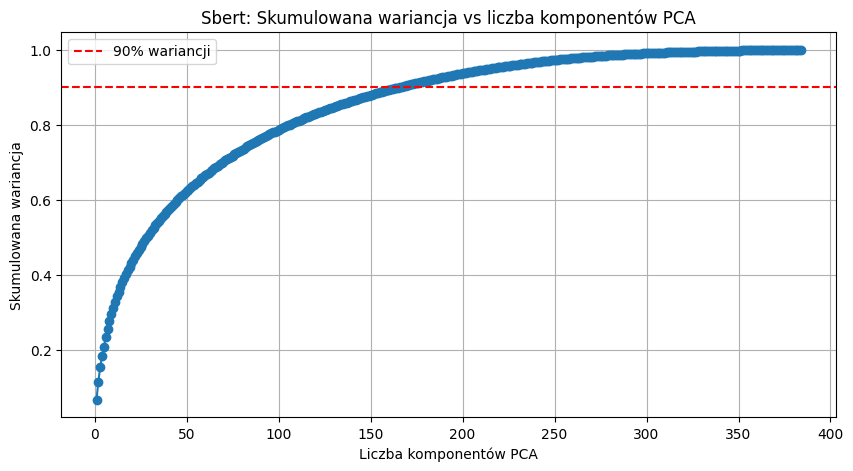

[Sbert] Liczba komponentów do 90% wariancji: 166


In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_sbert=PCA()

X_pca_sbert = pca_sbert.fit_transform(X_sbert)
explained_var_sbert = np.cumsum(pca_sbert.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var_sbert) + 1), explained_var_sbert, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% wariancji')
plt.title("Sbert: Skumulowana wariancja vs liczba komponentów PCA")
plt.xlabel("Liczba komponentów PCA")
plt.ylabel("Skumulowana wariancja")
plt.grid(True)
plt.legend()
plt.show()

n_components_sbert = np.argmax(explained_var_sbert >= 0.90) + 1
print(f"[Sbert] Liczba komponentów do 90% wariancji: {n_components_sbert}")

In [25]:
pca = PCA(n_components=n_components_sbert)
X_pca_sbert = pca.fit_transform(X_sbert)

In [26]:
X_pca_sbert.shape

(21197, 166)

### 🧠 Redukcja wymiarów embeddingów SBERT za pomocą PCA


In [27]:
import os
file_name = "X_sbert.npy"
sciezka_robocza = ""
full_path = os.path.join(sciezka_robocza, file_name)

# Zapis macierzy do pliku .npy
# np.save(full_path, X_sbert)
np.save(file_name, X_sbert)

In [28]:
sciezka_robocza="C:/Users/Mateu/OneDrive/Dokumenty/dane_do_amazona"
file_name = "X_sbert.npy"

import os 
import numpy as np
import pandas as pd

# df=pd.read_csv(os.path.join(sciezka_robocza,"amazon_reviews_processed.csv"))
# X_pca=np.load(os.path.join(sciezka_robocza,"X_pca.npy"))
# X_sbert=np.load(os.path.join(sciezka_robocza,file_name))


df=pd.read_csv("amazon_reviews_processed.csv")
X_pca=np.load("X_pca.npy")
X_sbert=np.load("X_sbert.npy")


## 🔍 Klasteryzacja recenzji

### 📌 KMeans


### 🔹 Podejście z embeddingami 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


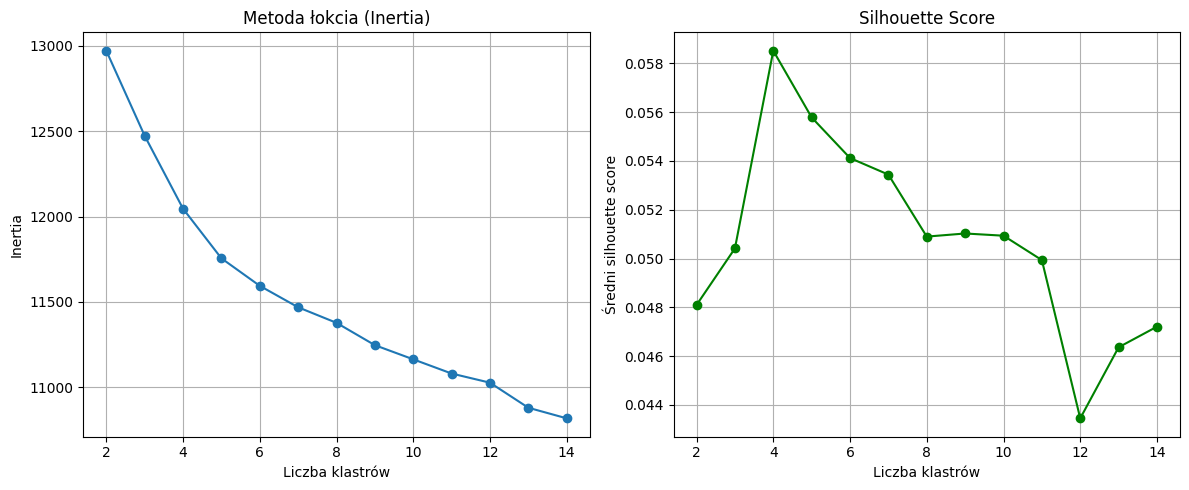

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Zakres liczby klastrów do sprawdzenia
cluster_range = list(range(2, 15))
inertia = []
silhouette_scores = []

# Testowanie różnych liczby klastrów
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca_sbert)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca_sbert, labels))

plt.figure(figsize=(12, 5))

# Wykres łokcia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title("Metoda łokcia (Inertia)")
plt.xlabel("Liczba klastrów")
plt.ylabel("Inertia")
plt.grid(True)

# Wykres silhouette score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Liczba klastrów")
plt.ylabel("Średni silhouette score")
plt.grid(True)

plt.tight_layout()
plt.show()


### 🔹 Podejście z reprezentacją TF-IDF

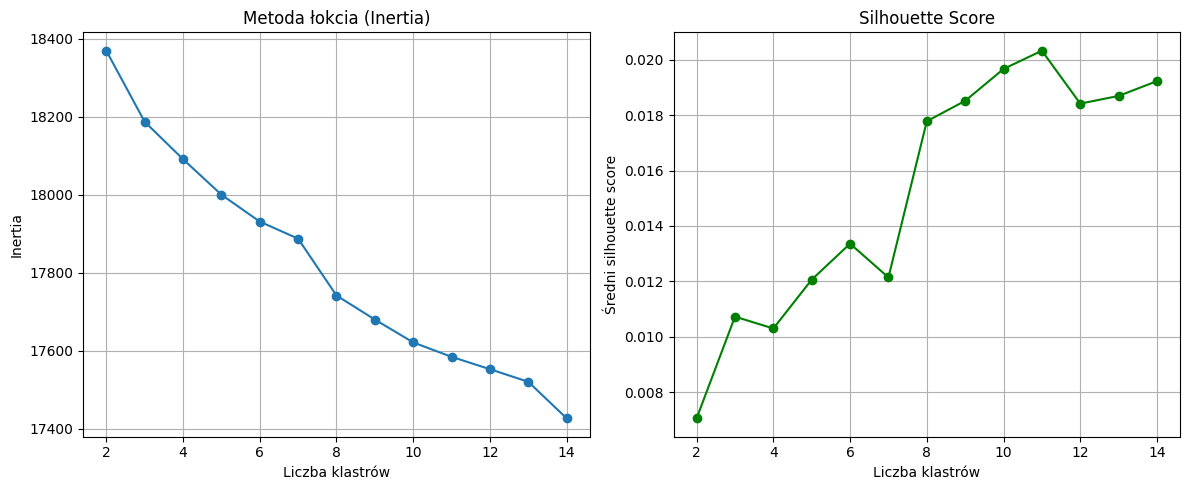

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Zakres liczby klastrów do sprawdzenia
cluster_range = list(range(2, 15))
inertia = []
silhouette_scores = []

# Testowanie różnych liczby klastrów
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

plt.figure(figsize=(12, 5))

# Wykres łokcia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title("Metoda łokcia (Inertia)")
plt.xlabel("Liczba klastrów")
plt.ylabel("Inertia")
plt.grid(True)

# Wykres silhouette score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Liczba klastrów")
plt.ylabel("Średni silhouette score")
plt.grid(True)

plt.tight_layout()
plt.show()


In [31]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_pca_sbert)

df['cluster_KMeans'] = kmeans.labels_

In [32]:
df['cluster_KMeans'].value_counts().sort_index()

cluster_KMeans
0    9010
1    4028
2    4910
3    3249
Name: count, dtype: int64

In [33]:
df.groupby('cluster_KMeans')[['length', 'vader_compound']].mean()

,length,vader_compound
cluster_KMeans,,
0,454.449834,0.705318
1,411.022840,0.699219
2,333.383910,0.558828
3,521.799015,0.668386


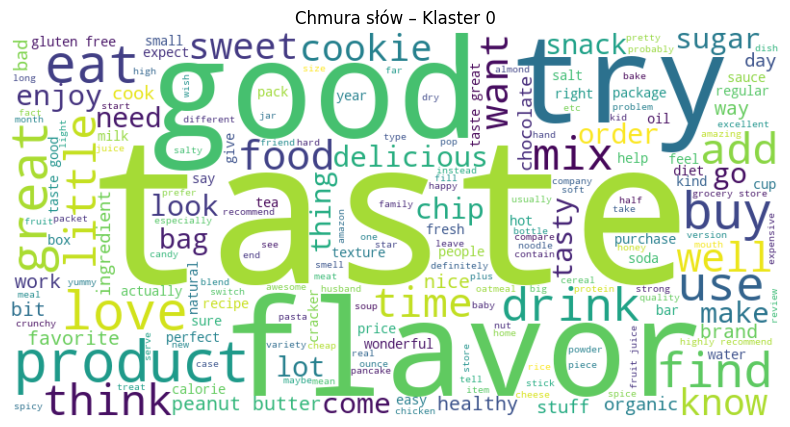

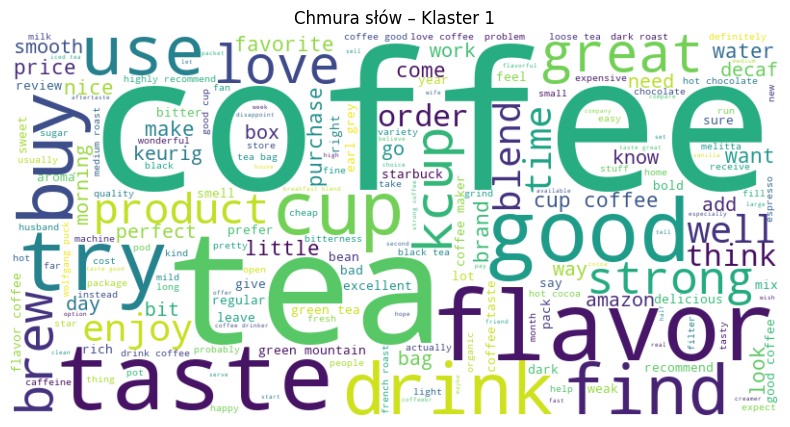

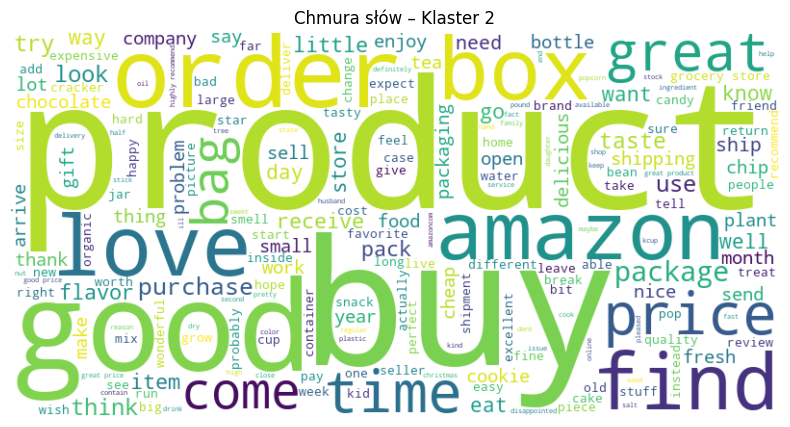

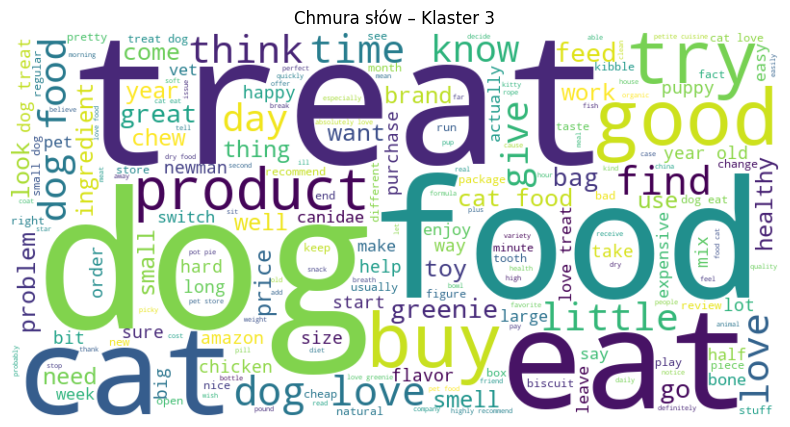

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for cluster_id in sorted(df['cluster_KMeans'].unique()):
    text = " ".join(df[df['cluster_KMeans'] == cluster_id]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Chmura słów – Klaster {cluster_id}')
    plt.show()

/Users/lila/Documents/RepozytoriumKlasteryzacja/CuMiDaKlasteryzacja/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


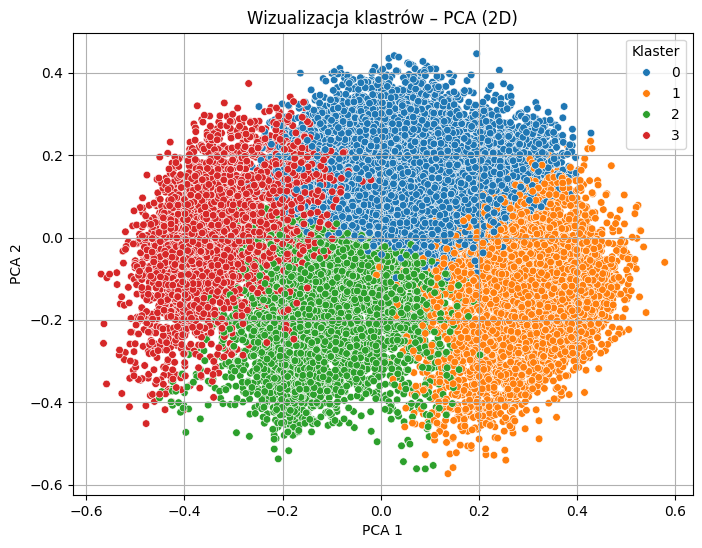

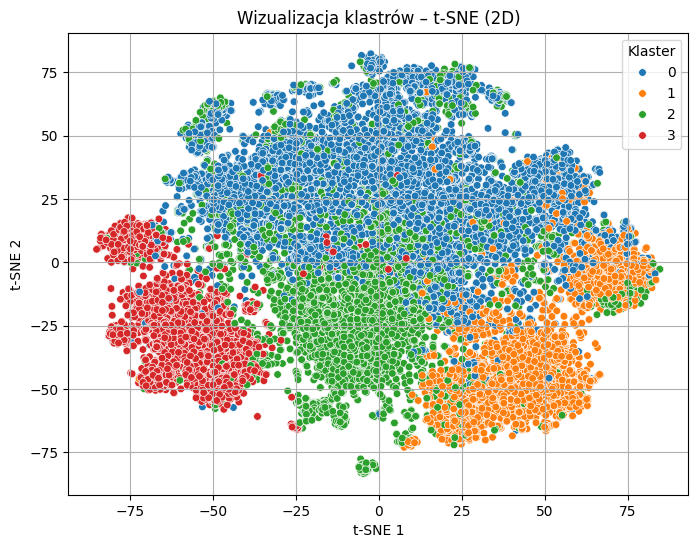

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# PCA 2D
pca_2d = PCA(n_components=2)
X_sbert_pca_2d = pca_2d.fit_transform(X_sbert)

# t-SNE 2D
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_sbert_tsne_2d = tsne_2d.fit_transform(X_sbert)

# Dodajemy do df
df["pca_1"] = X_sbert_pca_2d[:, 0]
df["pca_2"] = X_sbert_pca_2d[:, 1]
df["tsne_1"] = X_sbert_tsne_2d[:, 0]
df["tsne_2"] = X_sbert_tsne_2d[:, 1]

# Wykres PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="pca_1", y="pca_2", hue="cluster_KMeans", palette="tab10", s=30)
plt.title("Wizualizacja klastrów – PCA (2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Klaster")
plt.grid(True)
plt.show()

# Wykres t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="tsne_1", y="tsne_2", hue="cluster_KMeans", palette="tab10", s=30)
plt.title("Wizualizacja klastrów – t-SNE (2D)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Klaster")
plt.grid(True)
plt.show()

### Podsumowanie klastrów KMeans (SBERT)    (poprawiona kolejność)

**Klaster 0**  
🔹 Dłuższe recenzje  
🔹 Najwyższy sentyment (~0.71)  
🔹 Chmura zawiera: „taste”, „sweet”, „cookie”, „delicious”  
🔹 Możliwa grupa: bardzo pozytywne opinie o jedzeniu i słodyczach

**Klaster 1**  
🔹 Średnia długość tekstu: umiarkowana  
🔹 Średni sentyment: wysoki (~0.70)  
🔹 Chmura słów sugeruje tematy związane z napojami: „coffee”, „tea”, „taste”, „flavor”  
🔹 Możliwa grupa: pozytywne opinie o napojach

**Klaster 2**  
🔹 Najkrótsze recenzje  
🔹 Średni sentyment: najniższy (~0.56)  
🔹 Chmura słów zawiera ogólne słowa: „product”, „order”, „package”  
🔹 Możliwa grupa: krótkie i mniej entuzjastyczne recenzje

**Klaster 3**  
🔹 Najdłuższe recenzje  
🔹 Średni sentyment: umiarkowanie wysoki (~0.67)  
🔹 Dominują słowa: „treat”, „dog”, „cat”, „food”, „buy”  
🔹 Możliwa grupa: recenzje dotyczące karmy i produktów dla zwierząt

In [36]:
import os
import numpy as np

# Ścieżka robocza
sciezka_robocza = "C:/Users/Mateu/OneDrive/Dokumenty/dane_do_amazona"

# Zapisz df jako CSV
# df_path = os.path.join(sciezka_robocza, "df_clasters.csv")
df.to_csv("df_clasters.csv", index=False)

# Zapisz macierz X_pca_sbert jako .npy
# pca_path = os.path.join(sciezka_robocza, "X_pca_sbert.npy")
# np.save("X_pca_sbert.npy", X_pca_sbert)

# DBSCANN

# DBSCANN with sbert


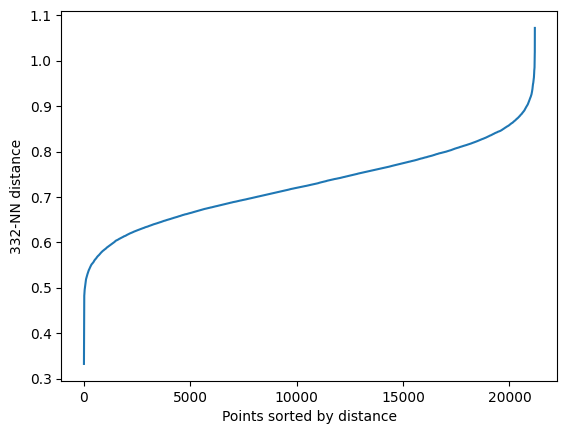

In [37]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=332)
nbrs = neigh.fit(X_pca_sbert)
distances, indices = nbrs.kneighbors(X_pca_sbert)

plt.plot(np.sort(distances[:, 4]))
plt.ylabel('332-NN distance')
plt.xlabel('Points sorted by distance')
plt.show()

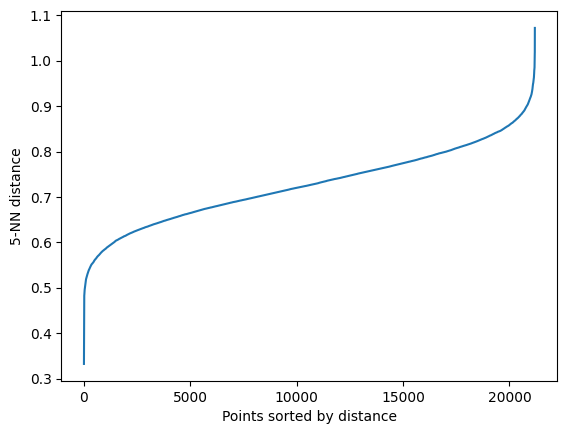

In [38]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=332)
nbrs = neigh.fit(X_pca_sbert)
distances, indices = nbrs.kneighbors(X_pca_sbert)

plt.plot(np.sort(distances[:, 4]))
plt.ylabel('5-NN distance')
plt.xlabel('Points sorted by distance')
plt.show()


In [39]:
def dbscan_and_visualization(X, eps, min_samples):
    from sklearn.cluster import DBSCAN
    import numpy as np
    import matplotlib.pyplot as plt


    dbscan = DBSCAN(eps=eps, min_samples=min_samples)  
    labels = dbscan.fit_predict(X)

    # Analiza wyników
    unique_labels, counts = np.unique(labels, return_counts=True)
    n_clusters = len(unique_labels) - 1  # -1 dla szumu
    noise_percentage = 100 * counts[0] / len(labels)

    print(f"Liczba klastrów: {n_clusters}")
    print(f"Procent szumu: {noise_percentage:.2f}%")

    # Wizualizacja (dla danych 2D/3D)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})\nClusters: {n_clusters}, Noise: {noise_percentage:.1f}%')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(scatter, label='Cluster ID')
    plt.show()

Zalecane parametry dla dbscanna, 166 kolumn dlatego min_samples = 332

Liczba klastrów: 1
Procent szumu: 4.93%


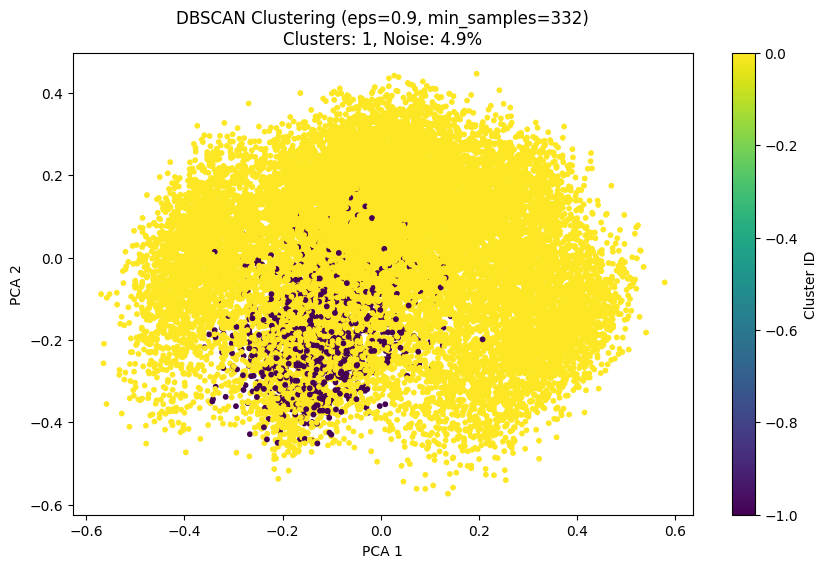

In [40]:
dbscan_and_visualization(X_pca_sbert, 0.9, 332)
